In [1]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
import random
import matplotlib.pyplot as plt
import numpy as np
import tkinter as tk
import numpy as np
import pandas as pd

In [2]:
# Define the Agent class for Trees
class TreeAgent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.on_fire = False
        self.time_on_fire = 0;

    def step(self):
        if (self.on_fire):
            # Get the current location of the tree
            x, y = self.pos
            
            # Define adjacent cell offsets (assuming 4 neighbors)
            neighbors = [(x + 1, y), (x - 1, y), (x, y + 1), (x, y - 1)]

             # If wind is high, include neighbors that are two cells away
            if self.model.wind == "high":
                neighbors.extend([(x + 2, y), (x - 2, y), (x, y + 2), (x, y - 2)])


            # Shuffle the list of neighbors randomly
            random.shuffle(neighbors)

            # Ignite up to two random adjacent cells
            ignited = 0
            for neighbor_x, neighbor_y in neighbors:
                if 0 <= neighbor_x < self.model.grid.width and 0 <= neighbor_y < self.model.grid.height:
                    if ignited < 1 and not self.model.grid.is_cell_empty((neighbor_x, neighbor_y)):
                        cell_contents = self.model.grid.get_cell_list_contents((neighbor_x, neighbor_y))
                        for agent in cell_contents:
                            if (isinstance(agent, TreeAgent) and (self.time_on_fire > 1 or self.model.wind=="high")):
                                self.model.ignite_tree(neighbor_x, neighbor_y)
                                ignited += 1
            self.time_on_fire = self.time_on_fire + 1
# Define the Agent class for Firefighters
class FirefighterAgent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.target_tree = None

    def step(self):
        # Find the nearest tree on fire
        nearest_fire_tree = self.find_nearest_fire_tree()

        if nearest_fire_tree:
            # Move to the nearest tree on fire
            current_position = self.pos
            delta_x = nearest_fire_tree.pos[0] - self.pos[0]
            delta_y = nearest_fire_tree.pos[1] - self.pos[1]
            
            if delta_x < 0:
                current_position = (current_position[0] - 1, current_position[1])
            elif delta_x > 0:
                current_position = (current_position[0] + 1, current_position[1])
            elif delta_y < 0:
                current_position = (current_position[0], current_position[1] - 1)
            elif delta_y > 0:
                current_position = (current_position[0], current_position[1] + 1)
            
            
            self.move_to_tree(current_position)

            # Extinguish the fire and remove the tree from the grid
            if (nearest_fire_tree.pos == current_position):
                # print('Gets extinguished')
                self.extinguish_and_remove_tree(nearest_fire_tree)

    def find_nearest_fire_tree(self):
        fire_trees = []

        # Iterate over all cells in the grid
        for x in range(self.model.grid.width):
            for y in range(self.model.grid.height):
                cell_contents = self.model.grid.get_cell_list_contents([(x, y)])
                for agent in cell_contents:
                    if isinstance(agent, TreeAgent) and agent.on_fire:
                        fire_trees.append(agent)

        if fire_trees:
            # Calculate distances to all fire trees
            distances = [self.distance_to_tree(tree) for tree in fire_trees]

            # Find the nearest fire tree
            nearest_index = distances.index(min(distances))
            return fire_trees[nearest_index]

        return None
    

    def distance_to_tree(self, tree):
        return manhattan_distance(self.pos, tree.pos)

    def move_to_tree(self, pos):
        # Move to the location of the target tree
        self.model.grid.move_agent(self, pos)
    
    def extinguish_and_remove_tree(self, tree):
        # Extinguish the fire in the tree
        tree.on_fire = False

# Define a class for Firebreak
class FirebreakAgent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.type = "Firebreak"  # Identify the agent type as Firebreak

    def step(self):
        pass  # FireBreak agents do not perform any actions
        
                
# Inside the BushfireModel class
class BushfireModel(Model):
    def __init__(self, width=20, height=20, tree_density=1, wind="none"):
        self.num_agents = width * height
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        self.wind = wind
        

        tree_counter = 0

        # Create and place Tree agents based on tree_density
        for i in range(width):
            for j in range(height):
                if random.random() < tree_density:
                    unique_id = f"Tree_{tree_counter}"  # Generate a unique ID based on the counter
                    tree = TreeAgent(unique_id, self)
                    self.grid.place_agent(tree, (i, j))
                    self.schedule.add(tree)
                    tree_counter += 1  # Increment the counter for the next tree agent

        # Define data collectors for model output
        self.datacollector = DataCollector(agent_reporters={"On Fire": lambda a: a.on_fire if isinstance(a, TreeAgent) else None})
        
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

    # Method to ignite a tree at a specified location
    def ignite_tree(self, x, y):
        cell_contents = self.grid.get_cell_list_contents([(x, y)])
        for agent in cell_contents:
            if isinstance(agent, TreeAgent):
                agent.on_fire = True
    
    # Method to extinguish a fire at a specified location
    def extinguish_tree_fire(self, x, y):
        cell_contents = self.grid.get_cell_list_contents([(x, y)])
        for agent in cell_contents:
            if isinstance(agent, TreeAgent) and agent.on_fire:
                agent.on_fire = False
                

    # Define a function to add FirebreakAgents to the model
    def add_firebreak(self, x, y, unique_id ):
        
        # Check if there are any agents at the specified location
        cell_contents = self.grid.get_cell_list_contents((x, y))

        # Remove any TreeAgent(s) from the location
        for agent in cell_contents:
            if isinstance(agent, TreeAgent):
                self.grid.remove_agent(agent)
                self.schedule.remove(agent)
                
        firebreak = FirebreakAgent(unique_id, self)  # Pass the unique ID and model reference
        self.grid.place_agent(firebreak, (x, y))
        self.schedule.add(firebreak)
                
def manhattan_distance(point1, point2):
    return abs(point1[0] - point2[0]) + abs(point1[1] - point2[1])

# Define a function to visualize the model's state
def visualize(model):
    grid_state = {"Empty": 0, "Tree": 1, "Firefighter": 2}
    width = model.grid.width
    height = model.grid.height

    grid_matrix = np.zeros((height, width))

    for x in range(width):
        for y in range(height):
            cell_contents = model.grid.get_cell_list_contents([(x, y)])

            if any(isinstance(agent, TreeAgent) for agent in cell_contents):
                grid_matrix[y][x] = grid_state["Tree"]
            elif any(isinstance(agent, FirefighterAgent) for agent in cell_contents):
                grid_matrix[y][x] = grid_state["Firefighter"]
            else:
                grid_matrix[y][x] = grid_state["Empty"]

    plt.imshow(grid_matrix, cmap="cool", interpolation="none")
    plt.colorbar(ticks=[0, 1, 2], label='Agent Type (0: Empty, 1: Tree, 2: Firefighter)')
    plt.title("Bushfire Simulation")
    plt.show()
    


In [4]:
import tkinter as tk  # Import Tkinter module

# Define functions for the simulation and GUI
def step_simulation():
    model.step()
    update_grid()

# Define a function to update the grid display
def update_grid():
    # Define colors for different agent types
    COLORS = {
        'T': 'green',  # Tree not on fire
        'F': 'red',    # Tree on fire
        'E': 'blue',   # Firefighter
        'B': 'gray',   # Firebreak agent
        'Bu': 'black', # Burnt Tree
        'S': 'yellow', # Extinguished tree
    }
    # Loop through agents to update the grid
    for agent in model.schedule.agents:
        x, y = agent.pos

        # Set the symbol based on agent type and state
        if isinstance(agent, TreeAgent):
            if agent.on_fire:
                if (agent.time_on_fire > 4):
                    agent.on_fire = False
                    symbol = 'Bu' # Burnt tree
                else:
                    symbol = 'F'  # Tree on fire
            elif (not agent.on_fire and agent.time_on_fire > 4):
                symbol = 'Bu' # Burnt tree
            elif (not agent.on_fire and agent.time_on_fire > 0 and agent.time_on_fire <= 4):
                symbol = 'S'
            else:
                symbol = 'T'  # Tree not on fire
        elif isinstance(agent, FirefighterAgent):
            symbol = 'E'  # Firefighter
        elif isinstance(agent, FirebreakAgent):
            symbol = 'B'  # FireBreak agent

        color = COLORS.get(symbol, 'white')  # Default to white if symbol not found
        # Update the label with the symbol
        grid[y][x].config(text=symbol, background=color)

        
     # Clear the cells where firefighters have moved away
    for x in range(model.grid.width):
        for y in range(model.grid.height):
            if grid[y][x].cget("text") == 'E':
                grid[y][x].config(text=' ')

    # Restore the real firefighter's symbol as 'E'
    for firefighter in model.schedule.agents:
        if isinstance(firefighter, FirefighterAgent):
            x, y = firefighter.pos
            grid[y][x].config(text='E')

def select_fire():
    global selected_agent
    selected_agent = 'fire'
    fire_button.config(relief=tk.SUNKEN)
    firefighter_button.config(relief=tk.RAISED)
    firebreak_button.config(relief=tk.RAISED)

def select_firefighter():
    global selected_agent
    selected_agent = 'firefighter'
    firefighter_button.config(relief=tk.SUNKEN)
    fire_button.config(relief=tk.RAISED)
    firebreak_button.config(relief=tk.RAISED)
    
def select_firebreak():
    global selected_agent
    selected_agent = 'firebreak'
    firebreak_button.config(relief=tk.SUNKEN)
    fire_button.config(relief=tk.RAISED)
    firefighter_button.config(relief=tk.RAISED)
    
# Create a button to toggle the wind parameter
def toggle_wind():
    current_wind = model.wind
    if current_wind == "none":
        model.wind = "high"
        wind_button.config(text="Wind: High")
    else:
        model.wind = "none"
        wind_button.config(text="Wind: None")

def countStats():
    numTree = 0
    numSavedTree = 0
    numBurntTree = 0
    untouchedTree = 0
    for agent in model.schedule.agents:
        if isinstance(agent, TreeAgent):
            numTree = numTree + 1
            if agent.on_fire:
                if (agent.time_on_fire > 4):
                    numBurntTree = numBurntTree + 1
            elif (not agent.on_fire and agent.time_on_fire > 4):
                numBurntTree = numBurntTree + 1
            elif (not agent.on_fire and agent.time_on_fire > 0 and agent.time_on_fire <= 4):
                numSavedTree = numSavedTree + 1
            else:
                untouchedTree = untouchedTree + 1
    print(f"Number of starting trees: {numTree}, Burnt trees: {numBurntTree}, Saved trees: {numSavedTree}")        

# Define a function to handle cell clicks and place the selected agent
def cell_click(event):
    x = event.widget.grid_info()['column']
    y = event.widget.grid_info()['row']
    
    if selected_agent == 'fire':
        model.ignite_tree(x, y)
    elif selected_agent == 'firefighter':
        firefighter = FirefighterAgent(model.random.randint(1, 1e6), model)
        model.grid.place_agent(firefighter, (x, y))
        model.schedule.add(firefighter)
    elif selected_agent == 'firebreak':
        model.add_firebreak(x, y, model.random.randint(1, 1e6))  # Create a firebreak at the clicked location
        
    
    update_grid()
    # Update the cell text
    event.widget.config(text=grid[y][x].cget("text"))
    
# Define a function to run the simulation automatically
def run_simulation_auto():
    num_steps_auto = int(num_steps_auto_var.get())
    for _ in range(num_steps_auto):
        model.step()
        update_grid()
        
def update_model_params():
    global model
    new_width, new_height, new_tree_density = 20,20,1
    if len(width_var.get()) != 0:
        new_width = int(width_var.get())
    if len(height_var.get()) != 0:
        new_height = int(height_var.get())
    if len(tree_density_var.get()) != 0:
        new_tree_density = float(tree_density_var.get())    
    
    # Update the model with new parameters
    model = BushfireModel(new_width, new_height, new_tree_density, wind="none")
    
    global grid
    grid = [[None for _ in range(width)] for _ in range(height)]
    for x in range(width):
        for y in range(height):
            cell = tk.Label(grid_frame, text=' ', width=2, height=1)
            cell.grid(row=y, column=x)
            cell.bind('<Button-1>', cell_click)
            grid[y][x] = cell
            
    update_grid()

# Define a function to exit the simulation cleanly
def exit_simulation():
    root.destroy()  # Close the Tkinter window and exit the simulation

# Create and run the model
width = 10
height = 10
tree_density = 1
num_firefighters = 1

model = BushfireModel(width, height, tree_density, wind="none")

# Create a Tkinter window
root = tk.Tk()
root.title("Bushfire Simulation")

# Create a frame for the grid display
grid_frame = tk.Frame(root)
grid_frame.pack()

# Set the initial selected agent to None
selected_agent = None

# Create a LabelFrame for group 1: Select agents
group1_frame = tk.LabelFrame(root, text="Select Agents")
group1_frame.pack(fill="both", expand="yes", padx=10, pady=5)

fire_button = tk.Button(group1_frame, text="Select Fire", command=select_fire)
fire_button.pack(side="left")

firefighter_button = tk.Button(group1_frame, text="Select Firefighter", command=select_firefighter)
firefighter_button.pack(side="left")

firebreak_button = tk.Button(group1_frame, text="Select Firebreak", command=select_firebreak)
firebreak_button.pack(side="left")

# Create a LabelFrame for group 2: Wind and Tree Density
group2_frame = tk.LabelFrame(root, text="Wind and Tree Density")
group2_frame.pack(fill="both", expand="yes", padx=10, pady=5)

wind_button = tk.Button(group2_frame, text="Wind: None", command=toggle_wind)
wind_button.pack(side="left")

tree_density_label = tk.Label(group2_frame, text="Tree Density:")
tree_density_label.pack(side="left")

tree_density_var = tk.StringVar()
tree_density_entry = tk.Entry(group2_frame, textvariable=tree_density_var)
tree_density_entry.pack(side="left")

# Create a LabelFrame for group 3: Width and Height
group3_frame = tk.LabelFrame(root, text="Width and Height")
group3_frame.pack(fill="both", expand="yes", padx=10, pady=5)

width_label = tk.Label(group3_frame, text="Width:")
width_label.pack(side="left")

width_var = tk.StringVar()
width_entry = tk.Entry(group3_frame, textvariable=width_var)
width_entry.pack(side="left")

height_label = tk.Label(group3_frame, text="Height:")
height_label.pack(side="left")

height_var = tk.StringVar()
height_entry = tk.Entry(group3_frame, textvariable=height_var)
height_entry.pack(side="left")

# Create a LabelFrame for group 4: Step and Steps to Run Automatically
group4_frame = tk.LabelFrame(root, text="Step and Steps to Run Automatically")
group4_frame.pack(fill="both", expand="yes", padx=10, pady=5)

step_button = tk.Button(group4_frame, text="Step", command=step_simulation)
step_button.pack(side="left")

label_num_steps_auto = tk.Label(group4_frame, text="Steps to Run Automatically:")
label_num_steps_auto.pack(side="left")

num_steps_auto_var = tk.StringVar()
entry_num_steps_auto = tk.Entry(group4_frame, textvariable=num_steps_auto_var)
entry_num_steps_auto.pack(side="left")

run_auto_button = tk.Button(group4_frame, text="Run Automatically", command=run_simulation_auto)
run_auto_button.pack(side="left")

# Create a LabelFrame for group 5: Apply Parameters and Exit
group5_frame = tk.LabelFrame(root, text="Apply Parameters and Exit")
group5_frame.pack(fill="both", expand="yes", padx=10, pady=5)

apply_parameters_button = tk.Button(group5_frame, text="Apply Parameters", command=update_model_params)
apply_parameters_button.pack(side="left")

get_statistics_button = tk.Button(group5_frame, text="Print Statistics", command=countStats)
get_statistics_button.pack(side="left")

exit_button = tk.Button(group5_frame, text="Exit", command=exit_simulation)
exit_button.pack(side="left")

# Initialize the grid display (create cell labels with "-" and bind cell clicks)
grid = [[None for _ in range(width)] for _ in range(height)]
for x in range(width):
    for y in range(height):
        cell = tk.Label(grid_frame, text=' ', width=2, height=1)
        cell.grid(row=y, column=x)
        cell.bind('<Button-1>', cell_click)
        grid[y][x] = cell
        
update_grid()

# Start the Tkinter main loop
root.mainloop()
update_grid()


TclError: invalid command name ".!frame.!label"

In [5]:
# Create a function to run the simulation with user-provided parameters and return the results
def run_simulation(grid_size, num_fires, num_firefighters, num_firebreaks, wind, num_steps, damage_threshold, num_simulations=1):
    results = []

    for _ in range(num_simulations):
        # Create and run the model
        model = BushfireModel(grid_size, grid_size, tree_density=1, wind=wind)

        # Randomly ignite trees to start fires
        for _ in range(num_fires):
            x, y = random.randint(0, grid_size - 1), random.randint(0, grid_size - 1)
            model.ignite_tree(x, y)

        firefighter_counter = 0

        # Add firefighters to the model with unique IDs
        for _ in range(num_firefighters):
            x, y = random.randint(0, grid_size - 1), random.randint(0, grid_size - 1)
            unique_id = f"Firefighter_{firefighter_counter}"  # Generate unique ID based on the counter
            firefighter = FirefighterAgent(unique_id, model)
            model.grid.place_agent(firefighter, (x, y))
            model.schedule.add(firefighter)
            firefighter_counter += 1  # Increment the counter for the next firefighter


        # Add firebreaks to the model
        firebreak_counter = 1

        for _ in range(num_firebreaks):
            x, y = random.randint(0, grid_size - 1), random.randint(0, grid_size - 1)
            unique_id = f"Firebreak_{firebreak_counter}"  # Create a unique ID for the FirebreakAgent
            model.add_firebreak(x, y, unique_id)
            
            firebreak_counter += 1


        # Simulate for the specified number of steps
        for _ in range(num_steps):
            model.step()

        # Calculate and store the statistics
        num_starting_trees, num_burnt_trees, num_saved_trees = count_stats_return(model)
        proportion_burnt = num_burnt_trees / num_starting_trees

        # Check if the damage was significant
        significant_damage = proportion_burnt > damage_threshold

        results.append({
            "Starting Trees": num_starting_trees,
            "Burnt Trees": num_burnt_trees,
            "Saved Trees": num_saved_trees,
            "Proportion Burnt": proportion_burnt,
            "Significant Damage": significant_damage
        })

    # Create a DataFrame from the results
    results_df = pd.DataFrame(results)
    
    return results_df


# Create a function to count statistics
def count_stats_return(model):
    num_tree = 0
    num_saved_tree = 0
    num_burnt_tree = 0

    for agent in model.schedule.agents:
        if isinstance(agent, TreeAgent):
            num_tree += 1
            if agent.on_fire:
                if agent.time_on_fire > 4:
                    num_burnt_tree += 1
            elif not agent.on_fire and agent.time_on_fire > 4:
                num_burnt_tree += 1
            elif not agent.on_fire and agent.time_on_fire > 0 and agent.time_on_fire <= 4:
                num_saved_tree += 1

    return num_tree, num_burnt_tree, num_saved_tree

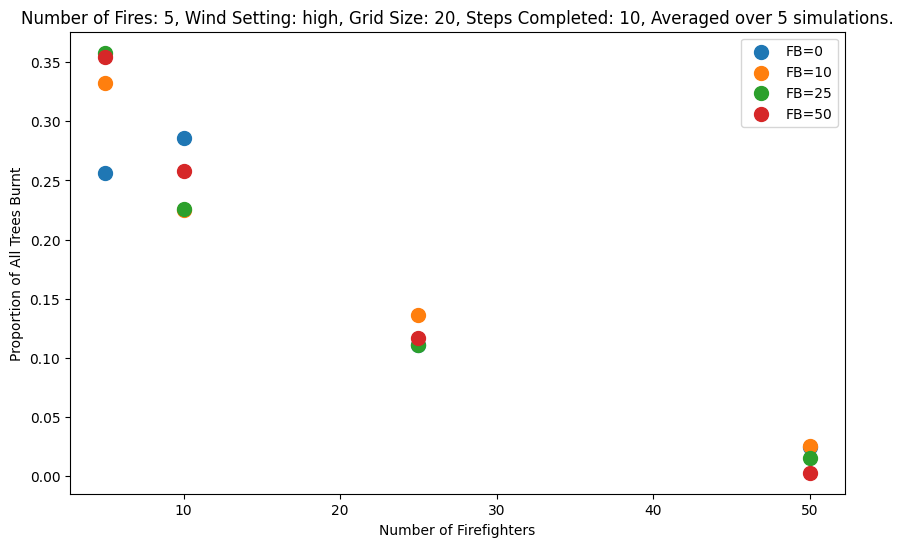

In [6]:
# Define grid size
# CHANGE THIS VALUE TO ALTER GRID SIZE, we left it at 20x20 for our experiments
grid_size = 20

# Define lists of values to test
# CHANGE THESE ARRAYS TO ALTER number of firefighter and firebreak pairs to test, arrays can be different sizes
firefighter_values = [5, 10, 25, 50]  # Vary the number of firefighters
firebreak_values = [0, 10, 25, 50]  # Vary the number of firebreaks


# Initialize an empty dictionary to store results
results = {}

# Get parameter values from user input
num_fires = int(input("Enter the number of fires: "))
wind = input("Enter wind condition (high/none): ")
num_steps = int(input("Enter the number of steps to simulate: "))
damage_threshold = float(input("Enter the damage threshold: "))
num_simulations = int(input("Enter the number of simulations: "))

# Define a color map with a limited number of colors
color_map = plt.get_cmap("tab10")

# Create a dictionary to map FB values to specific colors
fb_colors = {0: color_map(0), 10: color_map(1), 25: color_map(2), 50: color_map(3)}

# Create a dictionary to track which values have been added to the legend
legend_added = {}

# Create a graph to visualize the results
plt.figure(figsize=(10, 6))  # Increase the figure size

# Iterate over different numbers of firefighters and firebreaks
for num_firebreaks in firebreak_values:
    # Assign the color based on the FB value
    color = fb_colors[num_firebreaks]

    for num_firefighters in firefighter_values:
        # Initialize a list to store results for this combination
        proportion_burnt_results = []

        # Vary the number of firefighters and firebreaks for each simulation run
        for _ in range(num_simulations):
            # Run the simulation for the current combination of parameters
            result_df = run_simulation(grid_size, num_fires, num_firefighters, num_firebreaks, wind, num_steps, damage_threshold)

            # Read the required values from the DataFrame
            starting_trees = result_df['Starting Trees'].iloc[0]
            burnt_trees = result_df['Burnt Trees'].iloc[0]
            saved_trees = result_df['Saved Trees'].iloc[0]

            # Calculate the proportion of burnt trees based on the number of firefighters
            proportion_burnt = burnt_trees / starting_trees
            proportion_burnt_results.append(proportion_burnt)

        # Store the results for this combination of parameters
        results[(num_firefighters, num_firebreaks)] = proportion_burnt_results

        x_values = num_firefighters  # X-axis: Number of firefighters
        y_values = [np.mean(proportion_burnt_results)]  # Y-axis: Proportion of all trees burnt

        # Check if the FB value has already been added to the legend
        if num_firebreaks not in legend_added:
            plt.scatter(x_values, y_values, label=f"FB={num_firebreaks}", color=color, s=100)
            legend_added[num_firebreaks] = True
        else:
            plt.scatter(x_values, y_values, color=color, s=100)

# Add the number of fires, wind setting, and grid size to the graph title
title = f"Number of Fires: {num_fires}, Wind Setting: {wind}, Grid Size: {grid_size}, Steps Completed: {num_steps}, Averaged over {num_simulations} simulations."
plt.title(title)

# Set the axis labels and legend
plt.xlabel("Number of Firefighters")
plt.ylabel("Proportion of All Trees Burnt")
plt.legend()

# Show the plot
plt.show()
